In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import matplotlib as mpl

# dataset
dataset = "CIFAR10"
# model
model = "ResNet101"
# No of couples
alphas = [0]
# Base path
base_dir = "/network/rit/lab"

# Load CSV files
df_list = []
for alpha in alphas:
    model_dir = f"{model}-{dataset}"
    file_name = f"{model}-{dataset}-a{alpha}-epoch_results.csv"
    csv_path = os.path.join(base_dir, dataset, model_dir, file_name)
    
    if os.path.isfile(csv_path):
        print(f"Found file: {file_name}")
        df = pd.read_csv(csv_path)
        df['ALPHA'] = alpha
        df_list.append(df)
    else:
        print(f"Not Founded : {file_name} ????")

# Combine
if df_list:
    combined_df = pd.concat(df_list, ignore_index=True)
    print("\nAll available files loaded successfully.")
else:
    print("No files were found.")
    raise SystemExit

In [104]:
Val_Accs = {}
Val_Loss = {}
LR_dict = {}
min_losses = []
best_epochs = []
total_epochs = []

# Process each alpha's data
for alpha in alphas:
    alpha_df = combined_df[combined_df['ALPHA'] == alpha]
    alpha_df = alpha_df.reset_index(drop=True)

    if "Validation Accuracy" in alpha_df.columns:
        val_acc_list = alpha_df["Validation Accuracy"].dropna().tolist()
        val_loss_list = alpha_df["Validation Loss"].dropna().tolist()
        lr_list = alpha_df["LR"].dropna().tolist()

        Val_Accs[alpha] = val_acc_list
        Val_Loss[alpha] = val_loss_list
        LR_dict[alpha] = lr_list

        min_loss = min(val_loss_list)
        best_epoch = val_loss_list.index(min_loss) + 1

        min_losses.append(min_loss)
        best_epochs.append(best_epoch)
        total_epochs.append(len(Val_Accs[alpha]))

        print(f"ALPHA: {alpha}, Min Loss: {min_loss:.4f}, Best Epoch: {best_epoch}, Total Epoch: {len(Val_Accs[alpha])}")
    else:
        print(f"Missing 'Validation Accuracy' column in {alpha}")

# Find the LR with max length
jumps = []

max_epoch = max(best_epochs)
last_epoch = min(total_epochs)

# last_epoch = best_epochs[-1]
best_lr = LR_dict[list(Val_Accs.keys())[total_epochs.index(last_epoch)]][:last_epoch]
# find the sudden chnages of LR
for i in range(len(best_lr)-1):
    if best_lr[i] != best_lr[i+1]:
        print(best_lr[i+1], i+1+1)
        jumps.append(i+1+1)

max_epoch, last_epoch, jumps

ALPHA: 0, Min Loss: 0.2533, Best Epoch: 135, Total Epoch: 170
ALPHA: 8, Min Loss: 0.2607, Best Epoch: 74, Total Epoch: 109
ALPHA: 16, Min Loss: 0.2409, Best Epoch: 66, Total Epoch: 101
ALPHA: 32, Min Loss: 0.2527, Best Epoch: 74, Total Epoch: 109
0.01 31
0.001 61
0.0001 91


(135, 101, [31, 61, 91])

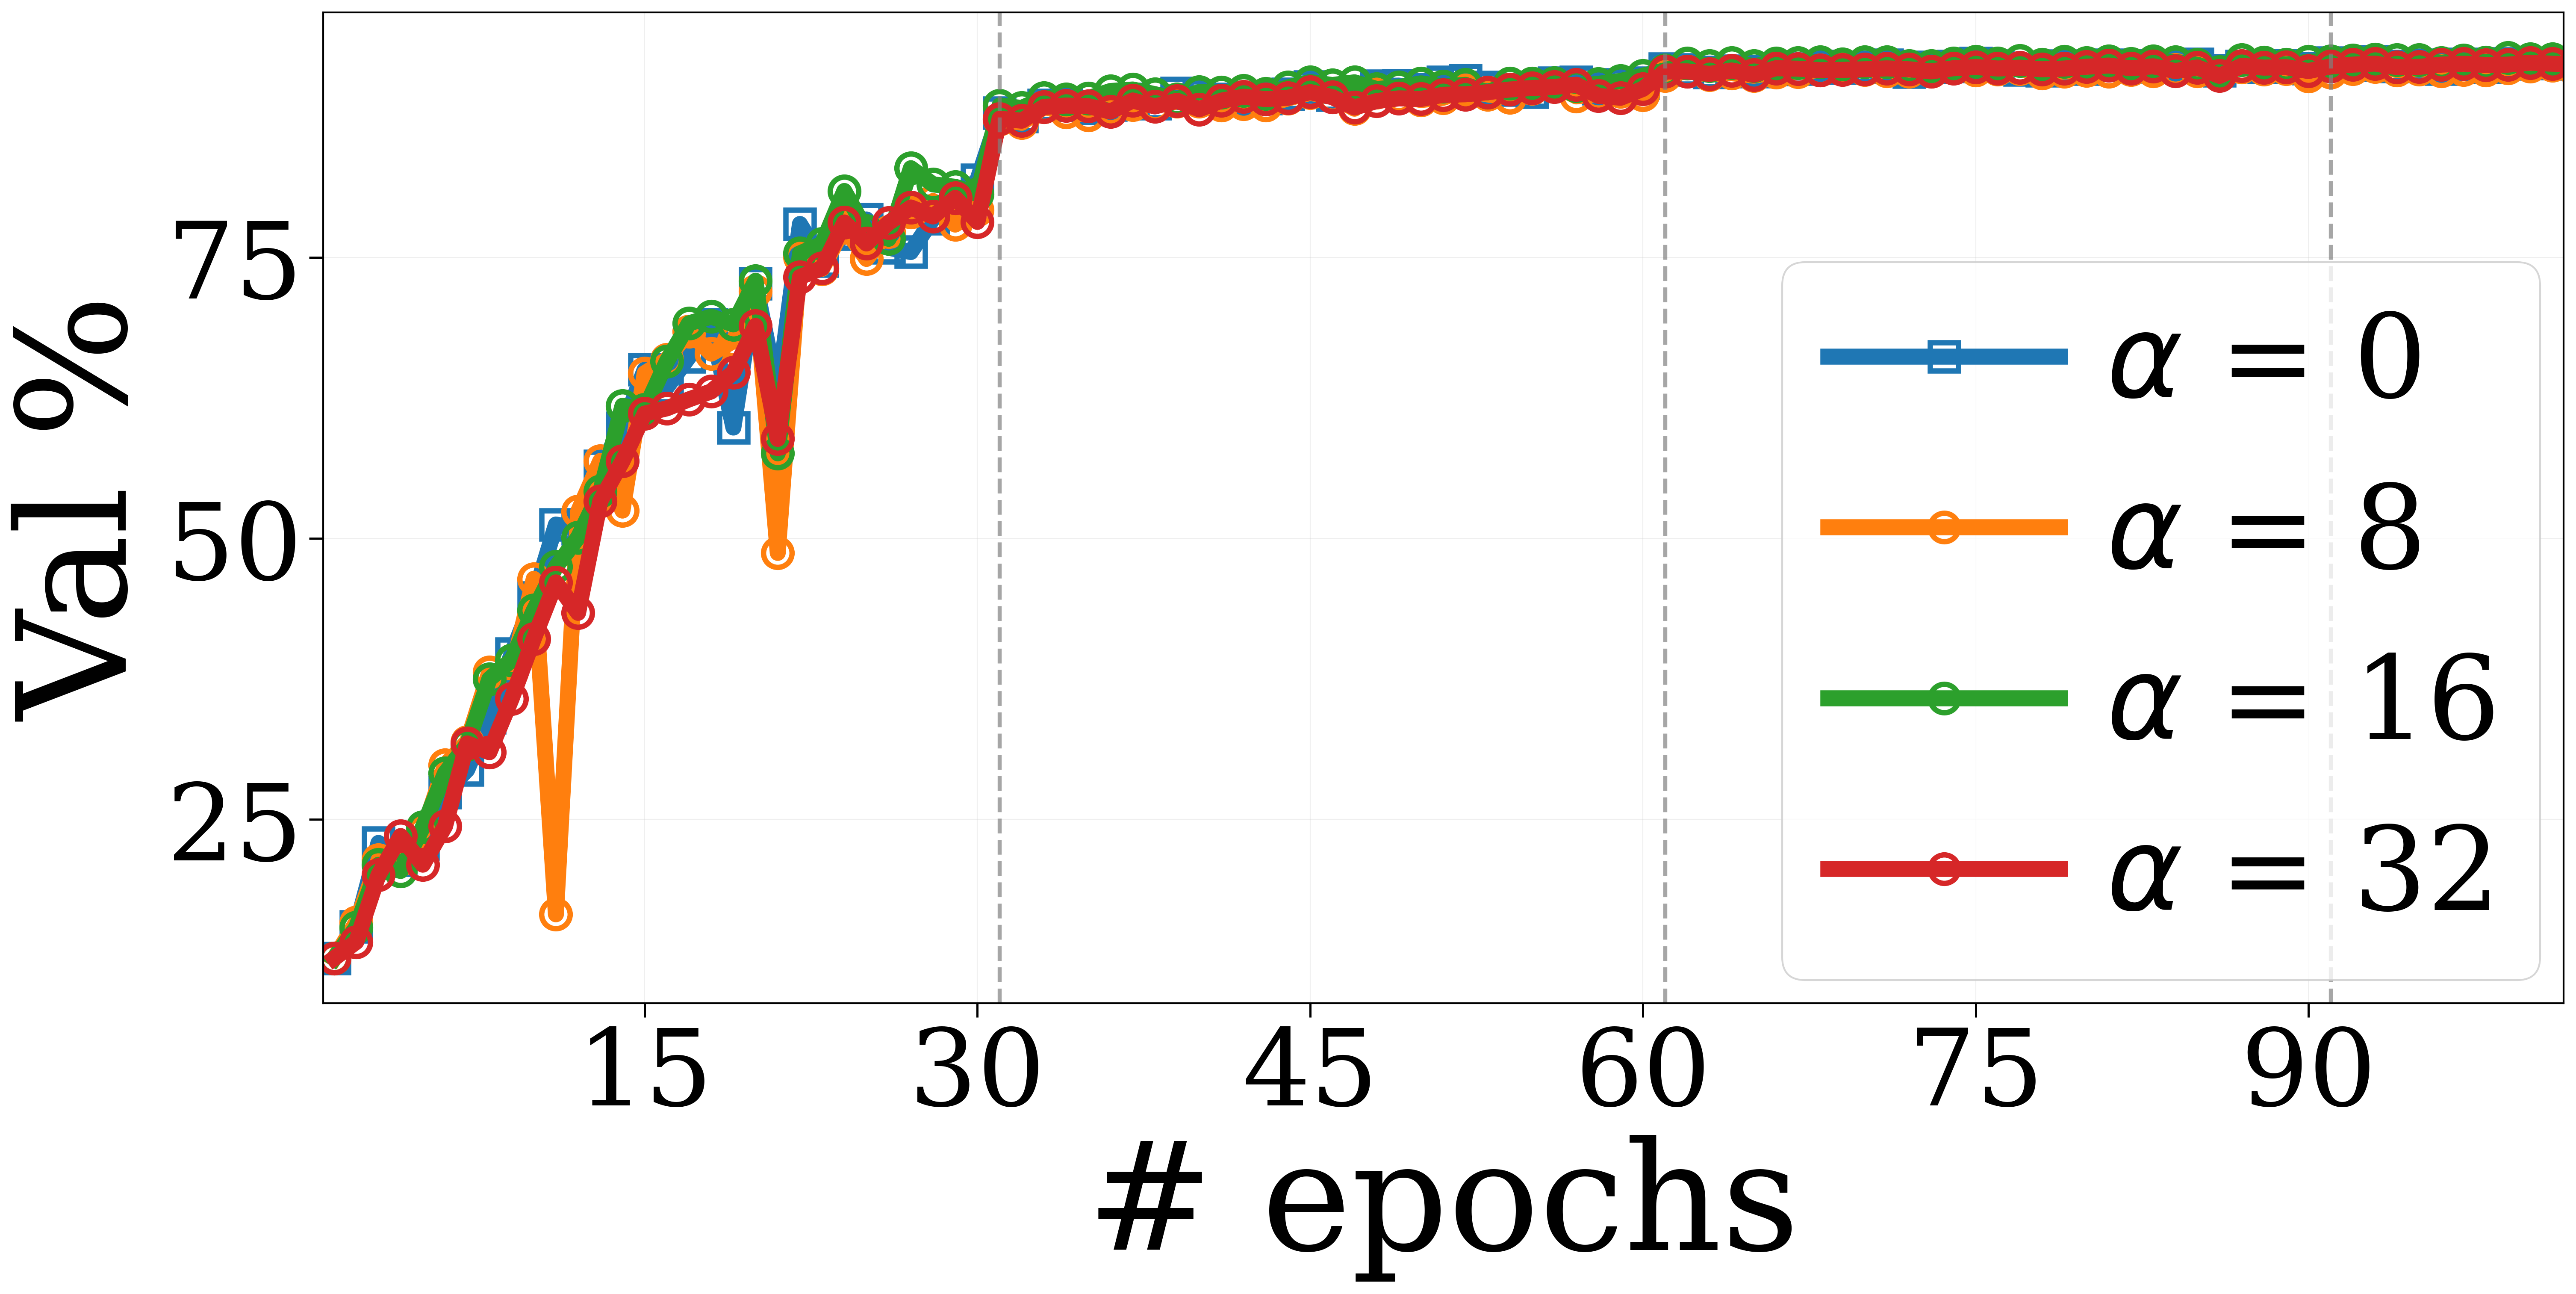

CIFAR10_ResNet101_Validation_Accuracy_Plot.pdf


In [ ]:
mpl.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "DejaVu Serif"],
    "axes.labelsize": 85,
    "xtick.labelsize": 60,
    "ytick.labelsize": 60,
    "legend.fontsize": 65,
    "axes.titlesize": 28,
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    "axes.spines.top": True,
    "axes.spines.right": True,
    "axes.linewidth": 1.5,
    "xtick.major.size": 8,
    "xtick.major.width": 1.2,
    "ytick.major.size": 8,
    "ytick.major.width": 1.2,
    "figure.dpi": 300,
})

alpha_color_map = {
    0:  'C0',
    8:  'C1',
    16: 'C2',
    32: 'C3',
}

marker_styles = {
    alphas[0]: 's',
    alphas[1]: 'o',
    alphas[2]: 'o',
    alphas[3]: 'o'
}

fig_width_in = 20 
fig_height_in = 10
fig, ax = plt.subplots(figsize=(fig_width_in, fig_height_in))

for side in ("left", "right", "top", "bottom"):
    ax.spines[side].set_visible(True)
    ax.spines[side].set_color("black")
    ax.spines[side].set_linewidth(1)
fig.patch.set_facecolor("white")

for idx, (alpha, val_acc_list) in enumerate(Val_Accs.items()):
    label = f"$\\alpha$ = {alpha}"
    epochs = list(range(1, len(val_acc_list) + 1))

    color = alpha_color_map.get(int(alpha), f"C{idx}")
    marker = marker_styles.get(alpha, 'o')

    ax.plot(
        epochs,
        val_acc_list,
        label=label,
        color=color,
        marker=marker,
        linewidth=9,
        markersize=16,
        linestyle='-',
        markerfacecolor='none',
        markeredgecolor=color,
        markeredgewidth=3.0
    )

ax.set_xlabel(r"# epochs")
ax.set_ylabel(r"Val %")

for jump_epoch in jumps:
    if jump_epoch <= last_epoch:
        plt.axvline(x=jump_epoch, color='gray', linestyle='--', linewidth=2.25, alpha=0.7)

ax.grid(axis='both', which='major', linestyle='-', linewidth=0.5, color='0.80', alpha=0.3)
ax.set_axisbelow(True)

ax.legend(
    loc='lower right',
    frameon=True, handlelength=2.0, columnspacing=1.0,
    handletextpad=0.4, title=None, ncol=1, borderaxespad=0.2,
)

plt.xlim(0.5, last_epoch+0.5)
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.tight_layout(pad=0.4)

pdf_name = f"{dataset}_{model}_Validation_Accuracy_Plot.pdf"
fig.savefig(pdf_name, bbox_inches="tight", pad_inches=0.02)
plt.show()
plt.close(fig)
print(pdf_name)
